# Supervised Learning Models for Classification of events text

- sklearn, naivebayes, logistic, linearsvc, mlp, decisiontree, wordcloud
- text classification, S&P Key Developments, Wharton Research Data Services 

Terence Lim

In [1]:
import numpy as np
import os
import time
import re
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from pandas import DataFrame, Series
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from finds.database import MongoDB
from finds.unstructured import Unstructured
from finds.structured import PSTAT
from settings import settings
mongodb = MongoDB(**settings['mongodb'])
keydev = Unstructured(mongodb, 'KeyDev')
imgdir = os.path.join(settings['images'], 'classify')
event_ = PSTAT.event_
role_ = PSTAT.role_

## Show event sample counts
counts = {ev: keydev['events'].count_documents({'keydeveventtypeid': ev})
          for ev in keydev['events'].distinct('keydeveventtypeid')}

## Retrieve headline+situation text
# - in lower case, exclude numeric
events = [28, 16, 83, 41, 81, 23, 87, 45, 80, 97,  231, 46, 31, 77, 29,
          232, 101, 42, 47, 86, 93, 3, 22, 102, 82]
corpus = {}    #[16, 83] # #[65, 80]: #[101, 192, 65, 80, 27, 86]
for event in events:
    docs = keydev['events'].find({'keydeveventtypeid':{'$eq':event}}, {'_id':0})
    corpus[event] = [re.sub(r'\b\w*[\d]\w*\b', ' ', " ".join(
        d[k] for k in ['headline', 'situation'])).lower() for d in docs]
DataFrame({e: {'event': event_[e], 'count': counts[e]} for e in corpus.keys()})

,28,16,83,41,81,23,87,45,80,97,...,232,101,42,47,86,93,3,22,102,82
event,Announcements of Earnings,Executive/Board Changes - Other,Private Placements,Product-Related Announcements,M&A Transaction Closings,Client Announcements,Fixed Income Offerings,Dividend Affirmations,M&A Transaction Announcements,Special/Extraordinary Shareholders Meeting,...,Buyback Transaction Announcements,Executive Changes - CEO,Debt Financing Related,Dividend Decreases,Follow-on Equity Offerings,Shelf Registration Filings,Seeking Acquisitions/Investments,Strategic Alliances,Executive Changes - CFO,M&A Transaction Cancellations
count,244140,128019,113007,93172,90955,90687,69652,53704,43305,32572,...,17420,16291,15184,15161,14687,12793,12736,12045,11698,10076


## Collect all text into data, and labels into y_all

In [2]:
lines = []
y_all = []
for label, event in enumerate(events):
    lines.extend(corpus[event])
    y_all.extend([event] * len(corpus[event]))
print(lines[0])

life healthcare group holdings limited reports audited consolidated earnings results for the year ended september  ,   life healthcare group holdings limited reported audited consolidated earnings results for the year ended september  ,  . for the year, the company reported revenue of zar  ,  million compared to zar  ,  million a year ago. operating profit was zar  ,  million compared to zar  ,  million a year ago. profit before tax was zar  ,  million compared to zar  ,  million a year ago. profit after tax was zar  ,  million compared to zar  ,  million a year ago. diluted earnings per share were  .  cents compared to  .  cents a year ago. 


# Pre-processing and Feature Extraction
## Tokenize

In [12]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r"\b[^\d\W][^\d\W][^\d\W]+\b")  # word len >= 2
lines = [" ".join(tokenizer.tokenize(line)) for line in lines]
print(lines[0])

life healthcar group hold limit report audit consolid earn result year end septemb life healthcar group hold limit report audit consolid earn result year end septemb year compani report revenu zar million compar zar million year ago oper profit zar million compar zar million year ago profit tax zar million compar zar million year ago profit tax zar million compar zar million year ago dilut earn per share cent compar cent year ago


In [4]:
words = Counter()
for line in lines:
    words.update(line.split())
DataFrame({'Unique Words': len(words)}, index=['Tokenized'])

,Unique Words
Tokenized,558422


## Zipf's Law

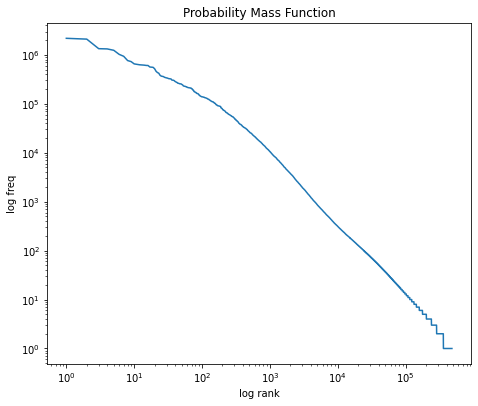

In [13]:
zipf =  Series(sorted(words.values(), reverse=True),
               index=np.arange(1,len(words)+1), name='freq')
zipf.plot(logx=True, logy=True, title='Probability Mass Function', c='C0',
          xlabel='log rank', ylabel='log freq', figsize=(7,6))
plt.tight_layout(pad=2)
plt.savefig(os.path.join(imgdir, 'zipfpre.jpg'))
plt.show()

## Remove stop words

In [5]:
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(s for s in stopwords.words('english') if "'" not in s)\
             .union(['yen', 'jpy', 'eur', 'dkk', 'cny', 'sfr'])
lines = [" ".join(word for word in line.split() if not word in stop_words)
         for line in lines]
print(lines[0])

life healthcare group holdings limited reports audited consolidated earnings results year ended september life healthcare group holdings limited reported audited consolidated earnings results year ended september year company reported revenue zar million compared zar million year ago operating profit zar million compared zar million year ago profit tax zar million compared zar million year ago profit tax zar million compared zar million year ago diluted earnings per share cents compared cents year ago


In [6]:
words = Counter()
for line in lines:
    words.update(line.split())
DataFrame({'Unique Words': len(words)}, index=['Removed Stopwords'])

,Unique Words
Removed Stopwords,558300


## Lemmatize

In [7]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
lines = [" ".join(lemmatizer.lemmatize(word) for word in line.split())
         for line in lines]
print(lines[0])    

life healthcare group holding limited report audited consolidated earnings result year ended september life healthcare group holding limited reported audited consolidated earnings result year ended september year company reported revenue zar million compared zar million year ago operating profit zar million compared zar million year ago profit tax zar million compared zar million year ago profit tax zar million compared zar million year ago diluted earnings per share cent compared cent year ago


In [9]:
words = Counter()
for line in lines:
    words.update(line.split())
DataFrame({'Unique Words': len(words)}, index=['Lemmatized'])

,Unique Words
Lemmatized,544054


## Stemming

In [10]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer(language='english')
lines = [" ".join(stemmer.stem(word) for word in line.split())
         for line in lines]
print(lines[0])

life healthcar group hold limit report audit consolid earn result year end septemb life healthcar group hold limit report audit consolid earn result year end septemb year compani report revenu zar million compar zar million year ago oper profit zar million compar zar million year ago profit tax zar million compar zar million year ago profit tax zar million compar zar million year ago dilut earn per share cent compar cent year ago


In [11]:
words = Counter()
for line in lines:
    words.update(line.split())
print(words.most_common(10))
DataFrame({'Unique Words': len(words)}, index=['Stemmed'])

[('million', 2180937), ('year', 2098973), ('ago', 1338540), ('compani', 1324416), ('announc', 1240636), ('share', 1025525), ('compar', 935672), ('earn', 765587), ('per', 729273), ('end', 654428)]


,Unique Words
Stemmed,480671


## Split Training and Test samples
- shuffled and stratified

In [25]:
#events = [28, 16, 83, 41, 81, 23, 87, 45, 80]  # Extract subset of data
#y_all, lines = Load('lines.multi')
data = [line for c, line in zip(y_all, lines) if c in events]
label = [c for c in y_all if c in events]
from sklearn.model_selection import train_test_split
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    data, label, test_size=test_size, random_state=42, stratify=label)
pd.concat([Series(y_train, name='train').value_counts()/len(y_train),
           Series(y_test, name='test').value_counts()/len(y_test)], axis=1).round(3).T

,28,16,83,41,81,23,87,45,80,97,...,232,101,42,47,86,93,3,22,102,82
train,0.199,0.105,0.092,0.076,0.074,0.074,0.057,0.044,0.035,0.027,...,0.014,0.013,0.012,0.012,0.012,0.01,0.01,0.01,0.01,0.008
test,0.199,0.105,0.092,0.076,0.074,0.074,0.057,0.044,0.035,0.027,...,0.014,0.013,0.012,0.012,0.012,0.01,0.01,0.01,0.01,0.008


## Vectorize it
- fit on train, transform on both train and test

In [26]:
from sklearn.feature_extraction import text
max_df, min_df, max_features = 0.5, 200, 10000
tfidf_vectorizer = text.TfidfVectorizer(
    encoding='latin-1',
    strip_accents='unicode',
    lowercase=True,
    #stop_words=stop_words,
    max_df=max_df,
    min_df=min_df,
    max_features=max_features,
    token_pattern=r"\b[^\d\W][^\d\W][^\d\W]+\b", #r'\b[^\d\W]+\b'
)
x_train = tfidf_vectorizer.fit_transform(X_train)   # sparse array
x_test = tfidf_vectorizer.transform(X_test)
feature_names = tfidf_vectorizer.get_feature_names()
print(len(feature_names), 'train:', x_train.shape, 'test:', x_test.shape)

7522 train: (979400, 7522) test: (244851, 7522)


# Train Classification Models

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
verbose=False
models={
    'naivebayes': MultinomialNB(),
    'logistic': LogisticRegression(class_weight='balanced', verbose=False,
                                   multi_class='multinomial', max_iter=500), 
    'linearsvc': LinearSVC(class_weight='balanced',
                           multi_class='ovr', verbose=verbose),
    'mlp': MLPClassifier(tol=0.001, verbose=verbose),  # No gpu in sklearn!
    'decisiontree': DecisionTreeClassifier(class_weight='balanced',
                                           random_state=0),
}
results = {}
for name, clf in models.items():
    #print('***', name, '***')
    tic = time.time()
    clf.fit(x_train, y_train)
    train_score = clf.score(x_train, y_train) # evaluate train set accuracy
    test_score = clf.score(x_test, y_test)    # and test set accuracy
    results.update({name: {'train_score': train_score,
                           'test_score': test_score, 
                           'elapsed': time.time() - tic}})
    #print(name, time.time() - tic, train_score, test_score)
r = DataFrame.from_dict(results, orient='index')
r

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,train_score,test_score,elapsed
naivebayes,0.862744,0.859184,4.934130
logistic,0.925051,0.917174,3115.048246
linearsvc,0.936322,0.924395,129.437485
mlp,0.988941,0.927250,4799.148670
decisiontree,0.999051,0.894822,4506.967757


## Show Decision Tree fitted parameters

In [53]:
dt = models['decisiontree']
x = dt.decision_path(x_test[-1])
DataFrame({'Tree depth': dt.get_depth(), 'Tree n_leaves': dt.get_n_leaves(),
           'Length of a test document': x_test[-1].nnz, 
           'Length of its decision path': x.nnz}, index=['DecisionTree'])

,Tree depth,Tree n_leaves,Length of a test document,Length of its decision path
DecisionTree,348,52586,24,206


## Show MLP parameters

In [48]:
mlp_params = DataFrame(models['mlp'].get_params(), index=['mlp'])
mlp_params[['activation', 'alpha', 'beta_1', 'beta_2', 'hidden_layer_sizes', 'momentum', 'solver']].T

,mlp
activation,relu
alpha,0.0001
beta_1,0.9
beta_2,0.999
hidden_layer_sizes,100
momentum,0.9
solver,adam


# Plot Train and Test Accuracy

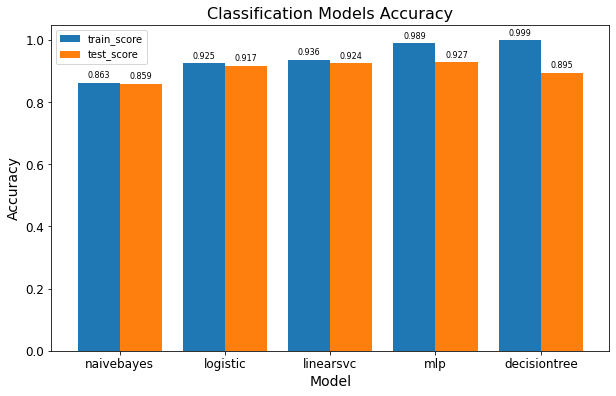

In [54]:
from finds.display import plot_bar
y = r[['train_score', 'test_score']]
fig, ax = plt.subplots(num=1, clear=True, figsize=(10,6))
plot_bar(y, ax=ax, labels=y.round(3).astype(str).values, fontsize=12,
         ylabel='Accuracy',
         title='Classification Models Accuracy', xlabel='Model')
plt.savefig(os.path.join(imgdir, 'mse.jpg'))
plt.show()

# Plot precision, recall, f1

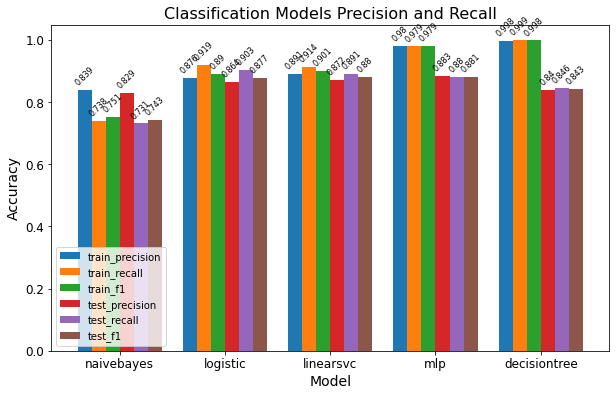

In [31]:
from sklearn import metrics
scores = {}
for ifig, (name, clf) in enumerate(models.items()):
    train = metrics.precision_recall_fscore_support(
        y_train, clf.predict(x_train), average='macro')[:3]
    test = metrics.precision_recall_fscore_support(
        y_test, clf.predict(x_test), average='macro')[:3]
    scores[name] = np.append(train, test)
y = DataFrame(scores, index=[t + '_' + s for t in ['train', 'test']
                             for s in ['precision','recall','f1']]).T
fig, ax = plt.subplots(num=1, clear=True, figsize=(10,6))
plot_bar(y, ax=ax, labels=y.round(3).astype(str).values, fontsize=12,
         ylabel='Accuracy', title='Classification Models Precision and Recall',
         xlabel='Model', rotation=45, loc='lower left')
plt.savefig(os.path.join(imgdir, 'accuracy.jpg'))
plt.show()


# Plot Feature Importances

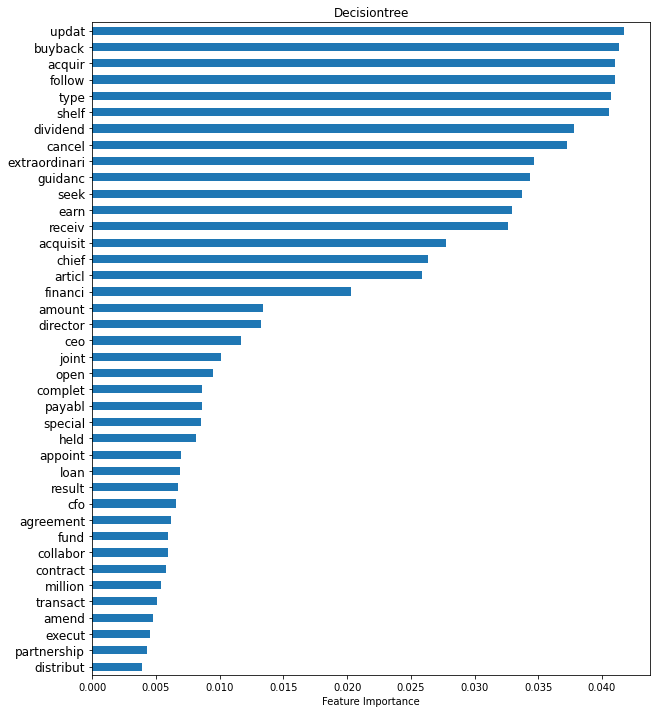

In [56]:
top_n = 40
for ifig, name in enumerate(['decisiontree']):
    clf = models[name]
    imp = clf.feature_importances_.flatten()
    words = Series({feature_names[i].replace(' ','_'): imp[i]
                    for i in np.argsort(abs(imp))})
    fig, ax = plt.subplots(clear=True, num=1, figsize=(10,12))
    words.iloc[-40:].plot(kind='barh', color='C0', ax=ax)
    ax.set_xlabel('Feature Importance')
    ax.set_title(name.capitalize())
    ax.yaxis.set_tick_params(labelsize=12)
    plt.savefig(os.path.join(imgdir, f"{name}.jpg"))
plt.show()

# Plot feature coefficient values by class (linear only)

Model: logistic


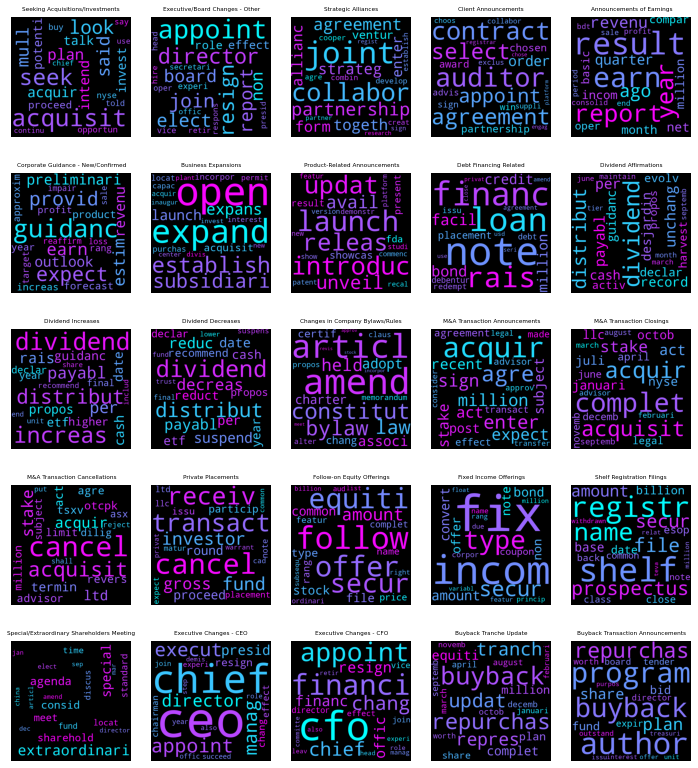

Model: naivebayes


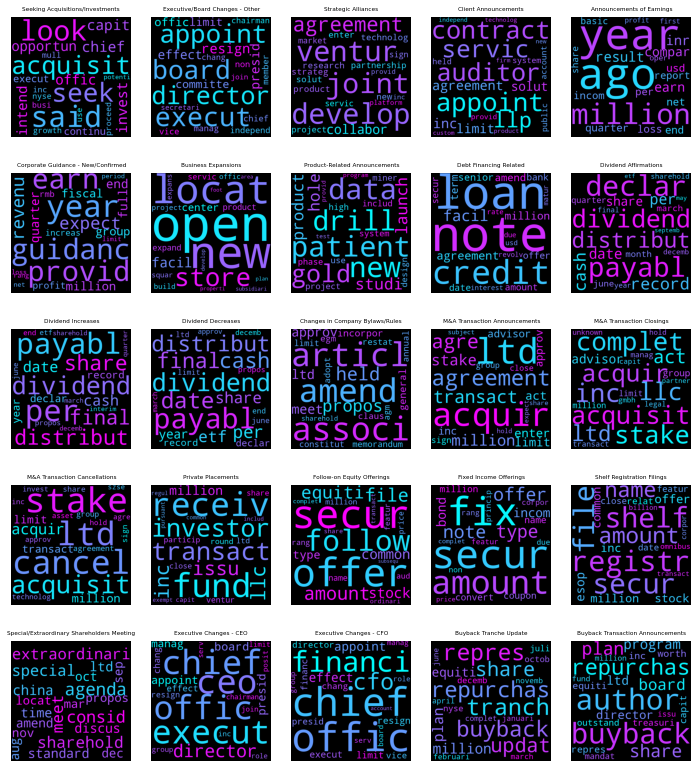

Model: linearsvc


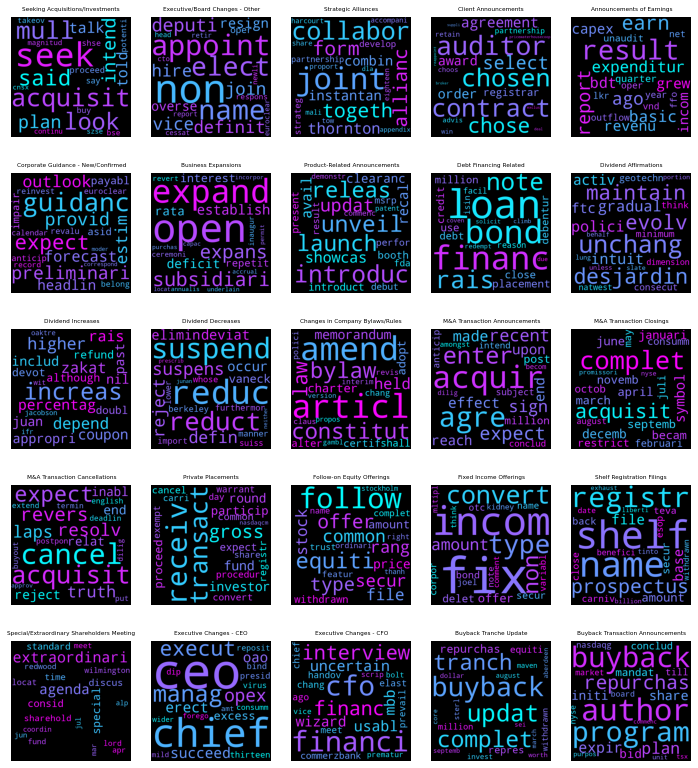

In [28]:
from wordcloud import WordCloud
wc = WordCloud(height=500, width=500, colormap='cool')
top_n = 20
for ifig, name in enumerate(['logistic', 'naivebayes', 'linearsvc']):
    print('Model:', name)
    clf = models[name]
    fig, axes = plt.subplots(5, 5, figsize=(10, 12), num=1+ifig, clear=True)
    axes = [ax for axs in axes for ax in axs]
    for topic, ax in enumerate(axes[:len(clf.classes_)]):
        #print("topic %d %s:" % (topic, event_[clf.classes_[topic]]))
        importance = clf.coef_[topic, :]
        words = {feature_names[i].replace(' ','_'): importance[i]
                 for i in importance.argsort()[:-top_n - 1:-1]}
        # print(words.keys())
        ax.imshow(wc.generate_from_frequencies(words))
        ax.axis("off")
        plt.tight_layout(pad=2)
        ax.set_title(f"{event_[clf.classes_[topic]]}", fontsize='xx-small')
    plt.savefig(os.path.join(imgdir, f"{name}.jpg"))
    plt.show()
    